# Demo of Recurrent Neural Networks

In [7]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import yfinance as yf

# Set Random seed
import random
random.seed(2505)


# Cleaning the Data 

In [8]:
# Download daily crude oil price data from Yahoo Finance
crude_oil = yf.download(tickers='CL=F', start='2015-12-20', end='2024-04-22', interval='1d')

# Explore the data
print(crude_oil.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2015-12-21  34.580002  34.860001  33.980000  34.740002  34.740002  298080
2015-12-22  35.799999  36.540001  35.660000  36.139999  36.139999  302263
2015-12-23  36.470001  37.950001  36.279999  37.500000  37.500000  374658
2015-12-24  37.860001  38.279999  37.380001  38.099998  38.099998  205873
2015-12-28  38.000000  38.090000  36.599998  36.810001  36.810001  220644


In [9]:
crude_oil

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-21,34.580002,34.860001,33.980000,34.740002,34.740002,298080
2015-12-22,35.799999,36.540001,35.660000,36.139999,36.139999,302263
2015-12-23,36.470001,37.950001,36.279999,37.500000,37.500000,374658
2015-12-24,37.860001,38.279999,37.380001,38.099998,38.099998,205873
2015-12-28,38.000000,38.090000,36.599998,36.810001,36.810001,220644
...,...,...,...,...,...,...
2024-04-15,85.930000,86.110001,84.050003,85.410004,85.410004,343894
2024-04-16,85.699997,86.180000,84.750000,85.360001,85.360001,241343
2024-04-17,85.360001,85.510002,82.550003,82.690002,82.690002,259540


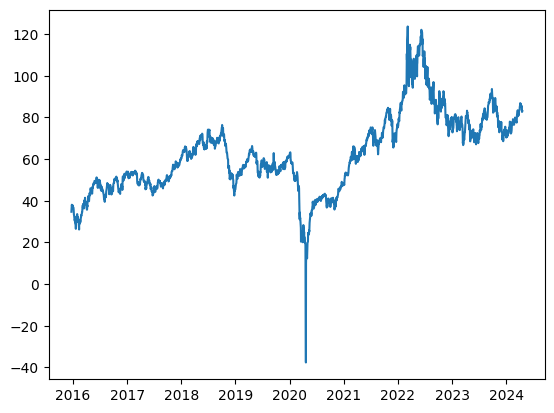

In [10]:
plt.plot(crude_oil['Adj Close'])

In [11]:
returns = crude_oil['Adj Close'].pct_change() # Used for univariate example.

column_names = crude_oil.columns
x = crude_oil.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [12]:
pct_c_crude_oil = df

In [13]:
pct_c_crude_oil.columns = column_names

In [14]:
pct_c_crude_oil

,Open,High,Low,Close,Adj Close,Volume
0,0.350353,0.181234,0.461176,0.448584,0.448584,0.130267
1,0.359152,0.195617,0.471603,0.457262,0.457262,0.132095
2,0.363984,0.207688,0.475452,0.465691,0.465691,0.163733
3,0.374008,0.210513,0.482279,0.469411,0.469411,0.089970
4,0.375018,0.208886,0.477438,0.461415,0.461415,0.096426
...,...,...,...,...,...,...
2090,0.720684,0.619981,0.771957,0.762660,0.762660,0.150288
2091,0.719025,0.620580,0.776302,0.762350,0.762350,0.105471
2092,0.716573,0.614845,0.762647,0.745801,0.745801,0.113424
2093,0.698038,0.597380,0.756502,0.746049,0.746049,0.036914


# Univariate Forecasting (RNN)

In [15]:
returns

Date
2015-12-21         NaN
2015-12-22    0.040299
2015-12-23    0.037631
2015-12-24    0.016000
2015-12-28   -0.033858
                ...   
2024-04-15   -0.002919
2024-04-16   -0.000585
2024-04-17   -0.031279
2024-04-18    0.000484
2024-04-19    0.004956
Name: Adj Close, Length: 2095, dtype: float64

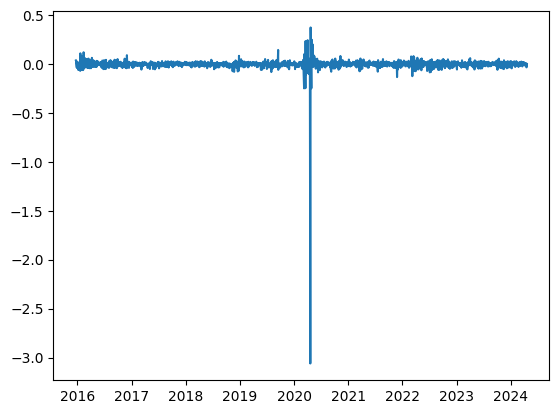

In [16]:
plt.plot(returns)

<Axes: >

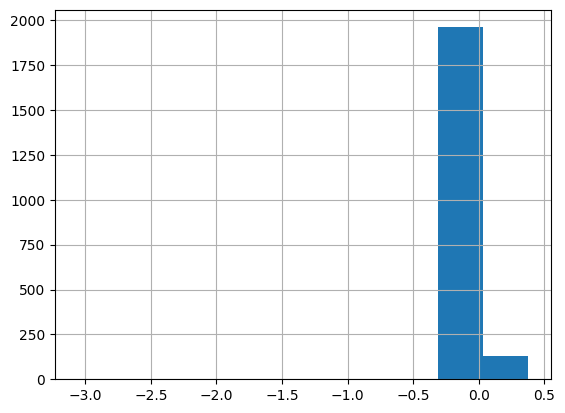

In [17]:
returns.hist()

In [18]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

2094
2094


In [19]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.90212566],
       [0.90134929],
       [0.89505426],
       [0.88054494],
       [0.8987782 ],
       [0.88063876],
       [0.89389661],
       [0.88819819],
       [0.88414404],
       [0.87421726]])]
Testing Data: Length is  1 :  [0.8844013588673252]


In [20]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (2084, 10, 1) Dimensions of Y (2084,)
Threshold is 1876


In [21]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 3 units.
model.add(layers.SimpleRNN(3,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Fitting the data
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1775 - val_loss: 0.0402
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0878 - val_loss: 0.0128
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 - val_loss: 0.0072
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530 - val_loss: 0.0061
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0567 - val_loss: 0.0044
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - val_loss: 0.0036
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - val_loss: 0.0017
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0384 - val_loss: 0.0018
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 - val_loss: 0.0021
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0030
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0034
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

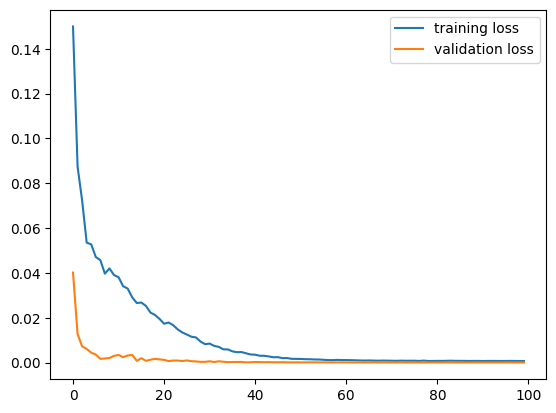

In [23]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

# Multi-Step Forecast

In [24]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions

true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]
for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

Number of Forecasts to do:  208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

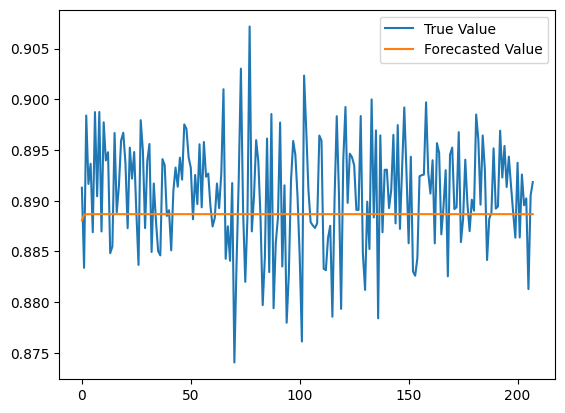

In [25]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

In [28]:
pct_c_crude_oil

,Open,High,Low,Close,Adj Close,Volume
0,0.350353,0.181234,0.461176,0.448584,0.448584,0.130267
1,0.359152,0.195617,0.471603,0.457262,0.457262,0.132095
2,0.363984,0.207688,0.475452,0.465691,0.465691,0.163733
3,0.374008,0.210513,0.482279,0.469411,0.469411,0.089970
4,0.375018,0.208886,0.477438,0.461415,0.461415,0.096426
...,...,...,...,...,...,...
2090,0.720684,0.619981,0.771957,0.762660,0.762660,0.150288
2091,0.719025,0.620580,0.776302,0.762350,0.762350,0.105471
2092,0.716573,0.614845,0.762647,0.745801,0.745801,0.113424
2093,0.698038,0.597380,0.756502,0.746049,0.746049,0.036914


# Multi-Variate Forecasting

# Using our Training and Testing sets, Let's create our inputs.

In [30]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_crude_oil.shape[0] - samples):
    X.append(pct_c_crude_oil.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_crude_oil.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.35035339, 0.18123449, 0.46117559, 0.44858367, 0.44858367],
       [0.35915187, 0.19561682, 0.47160325, 0.45726152, 0.45726152],
       [0.36398384, 0.20768771, 0.47545154, 0.46569145, 0.46569145],
       [0.37400836, 0.21051279, 0.48227919, 0.46941053, 0.46941053],
       [0.37501802, 0.20888623, 0.47743776, 0.46141451, 0.46141451],
       [0.36564257, 0.20760208, 0.47781019, 0.46798488, 0.46798488],
       [0.37040242, 0.20297921, 0.47619639, 0.46011282, 0.46011282],
       [0.36643589, 0.20631796, 0.47507914, 0.46284016, 0.46284016],
       [0.37213325, 0.2114545 , 0.47576191, 0.46110457, 0.46110457],
       [0.36708496, 0.20041091, 0.47209981, 0.45620779, 0.45620779]])]
Testing Data: Length is  1 :  [array([0.24639612])]


In [31]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (2085, 10, 5) Dimensions of Y (2085, 1)


In [32]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1876, 10, 5) (1876, 1) Testing Length: (209, 10, 5) (209, 1)


In [33]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 30 internal units.
model.add(layers.SimpleRNN(30,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(trainX.shape[1], trainX.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111 (4.34 KB)

 Trainable params: 1,111 (4.34 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1803 - val_loss: 0.0049
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - val_loss: 0.0034
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - val_loss: 0.0038
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - val_loss: 0.0038
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.0037
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0041
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 - val_loss: 0.0034
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0043
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.0035
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - val_loss: 0.0031
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0046
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

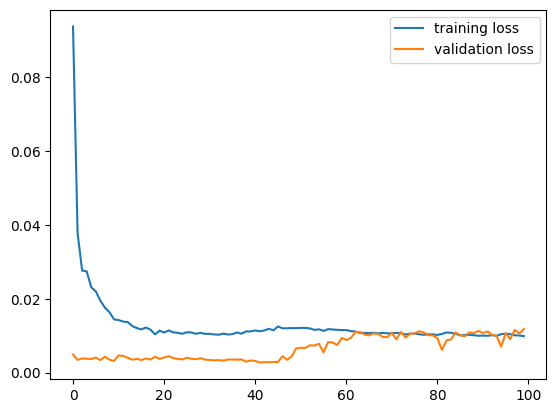

In [35]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


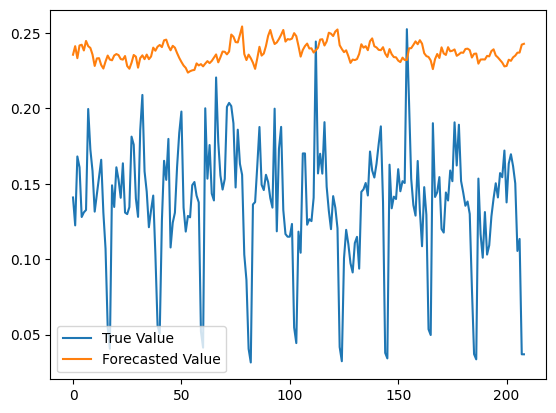

In [36]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [37]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
# Very much different from a univariate -- You will need predictions (or known) values for your independent values.
# Nonetheles, you will follow the same steps as shown for the univariate multi-step process.

In [38]:
len(X[threshold:])

209